# NOTE TO THE EVALUATOR, PLEASE READ

The notebook takes data from a local directory namely <code>folder_path = './Assignment3_dataset/' </code>. It was suggested in the course discussion forum to upload data along with the notebook. As the dataset provided was of 82 MB , it was impossible to upload it on moodle(Limit exceded).<br><br>
This code will run properly in any directory where the extracted folder <code>Assignment3_dataset</code> is present. Futhermore All the plots and images are already presented by submittiong the executed notebook.<br><br>
All the imports that are used in this notebook are colledted together in the Import subsection below. All these imported smoothly on Google Collab and no error or requirement is shown.

# Imports

In [1]:
import torch
import torch.utils.data
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import torchvision
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt

import argparse
import os
import random

import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torch.utils.data import Subset
from torchvision.transforms import InterpolationMode
from torch.optim.lr_scheduler import StepLR


# Helper Functions

In [2]:
def plot_images(X, batch=True, save=False, title='one'):
    
    """
    Plots batch of images as well as normal single image 
    Input is X : torch tensor : shape batch x 3 x h x w
    """
    
    if batch:
        # Assuming you have a batch of images with shape Bx3x64x64
        num_cols = 8  # Specify the number of rows and columns in the grid
        num_rows = len(X)//num_cols if len(X)//num_cols else 1 

        # Create a figure and a grid of subplots to display the images
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols, num_rows))

        # Iterate through the batch and plot each image in the grid
        for i in range(num_rows):
            for j in range(num_cols):
                idx = i * num_cols + j
                image = X[idx].permute(1, 2, 0).numpy()  # Convert to HxWxC format
                axs[i, j].imshow((image*255).astype("uint8"))
                axs[i, j].axis('off')

        # Adjust spacing and layout
        # Reduce spacing between subplots
        plt.subplots_adjust(wspace=0.025, hspace=0.025)
        
        # Save the subplots as an image
        if save:
            plot_name = title + '.png' 
            plt.savefig(plot_name)
            
    else:
        # Note here X should be an image 3xhxw
        plt.figure(figsize=(2, 2))
        plt.imshow(np.transpose(X, (1, 2, 0)))

    # Show the plot
    plt.show()

In [3]:
def compare_images(image1, image2, scale=1):
    
    # images are torch tensors
    image1 = np.transpose(image1.numpy(),(1,2,0))
    image2 = np.transpose(image2.numpy(),(1,2,0))
        
    # Create a new figure
    fig, axes = plt.subplots(1, 2, figsize=(scale*8, scale*4))  # Create a 1x2 grid of subplots

    # Plot image1 on the first subplot
    axes[0].imshow(image1)
    axes[0].axis('off')  # Turn off axis labels
    axes[0].set_title(f'Initial Image')

    # Plot image2 on the second subplot
    axes[1].imshow(image2)
    axes[1].axis('off')  # Turn off axis labels
    axes[1].set_title(f'Transformed Image')

    # Adjust spacing between the subplots
    plt.subplots_adjust(wspace=0.1)

    # Show the combined figure with both images side by side
    plt.show()
    

In [4]:
def augment_data(X, plot=False):
    
    if plot:
        print("########## ORIGINAL IMAGES ##########")
        plot_images(X)

    # Gamma balance the image
    gamma = 1.8
    X_gamma =  torch.clamp(X * gamma, 0, 1)
    if plot:
        print("########## GAMMA IMAGES ##########")
        plot_images(X_gamma)

    # Sharpen the images
    X_sharper = torchvision.transforms.functional.adjust_sharpness(X_gamma, sharpness_factor=3.5)
    if plot:
        print("########## SHARPER IMAGES ##########")
        plot_images(X_sharper)

    # Rotate the images +5
    X_rotated_plus = torchvision.transforms.functional.rotate(X_sharper,angle=5, interpolation= InterpolationMode.BILINEAR)
    if plot:
        print("########## +5 ROTATED IMAGES ##########")
        plot_images(X_rotated_plus)

    # Rotate the images -5
    X_rotated_minus = torchvision.transforms.functional.rotate(X_sharper,angle=-5, interpolation= InterpolationMode.BILINEAR)
    if plot:
        print("########## -5 ROTATED IMAGES ##########")
        plot_images(X_rotated_minus) 

    # Concatenate images
    X_out = torch.cat((X_sharper, X_rotated_plus, X_rotated_minus), dim=0)

    # Flip the images
    X_flipped = torchvision.transforms.functional.hflip(X_sharper)
    if plot:
        print("########## FLIPPED IMAGES ##########")
        plot_images(X_flipped) 

    # Rotate the flipped images +5
    X_flipped_rotated_plus = torchvision.transforms.functional.rotate(X_flipped ,angle=5, interpolation= InterpolationMode.BILINEAR)
    if plot:
        print("########## FLIPPED +5 ROTATED IMAGES ##########")
        plot_images(X_flipped_rotated_plus)

    # Rotate the flipped images -5
    X_flipped_rotated_minus = torchvision.transforms.functional.rotate(X_flipped ,angle=-5, interpolation= InterpolationMode.BILINEAR)
    if plot:
        print("########## FLIPPED -5 ROTATED IMAGES ##########")
        plot_images(X_flipped_rotated_minus)

    # Concatenate images
    X_out = torch.cat((X_out , X_flipped, X_flipped_rotated_plus, X_flipped_rotated_minus), dim=0)
    
    return X_out
    

In [5]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [6]:
def seed_all(seed_val=42):
    # Set the seed for the random number generator in PyTorch
    torch.manual_seed(seed_val)

    # Set the seed for the random number generator in the Python standard library (random module)
    random.seed(seed_val)

    # Set the seed for the random number generator in NumPy
    np.random.seed(seed_val)

    # Set the seed for the CUDA (GPU) operations if you are using GPUs
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_val)
        torch.cuda.manual_seed_all(seed_val)

    # Additional configurations for deterministic behavior (not always necessary)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# PROBLEM STATEMENT
## [Use only Python] Choose a category C of your choice and construct a data set D containing 90% images from the category C of the data. Construct a validation set V using the remaining 10% images. The first question is about constructing a Deep Convolutional GAN to generate images similar to those in category C. Please note that you need to choose only a single category (either boat or bus or car) for this exercise. Answers generating all three categories of objects will not be considered.

### Read Folder Path and image Paths

In [7]:
chosen_class = 'bus'     # Choose Category 'boat' 'bus' or 'car' (here C)
desired_width = 64
desired_height = 64
folder_path = './Assignment3_dataset/' 

class_names = os.listdir(folder_path)   # A list of images in folder path
print(f'Total classes in folder : {len(class_names)}')

Total classes in folder : 3


### Read All Images in the folder

In [8]:
# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available()  else "cpu")

In [9]:
# Create the dataset
dataset = datasets.ImageFolder(root=folder_path,
                               transform=transforms.Compose([
                               transforms.Resize((desired_height,desired_width)),
                               transforms.ToTensor(),
                           ]))


# Filter data according to desired class
print(f'Class to id dictionary : {dataset.class_to_idx}')
chosen_class_id = dataset.class_to_idx[chosen_class]
print(f'Index of the desired class : {chosen_class_id} ')

class_indices = []
for i in range(len(dataset)):
    if dataset.imgs[i][1]==chosen_class_id:
        class_indices.append(i)
subset = Subset(dataset, class_indices)

all_data = []
for idx in range(len(subset)):
    data, target = subset[idx]
    all_data.append((data, target))

d_loader = DataLoader(subset, batch_size=len(subset))
for batch in d_loader:
    X_all, _ = batch  # data and target are torch tensors


Class to id dictionary : {'boat': 0, 'bus': 1, 'car': 2}
Index of the desired class : 1 


#################### SOME IMAGES FOR THE CATEGORY ####################


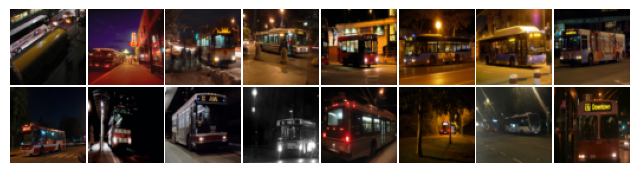

In [10]:
print("#################### SOME IMAGES FOR THE CATEGORY ####################")
plot_images(X_all[:16])

### 90-10 split the images

## SOL : DATASET D and V

In [11]:
from sklearn.model_selection import train_test_split
D, V = train_test_split(X_all, test_size=0.1, random_state=42)
print(f"Images in the train set D : {D.shape[0]}")
print(f"Images in the test set V : {V.shape[0]}")

Images in the train set D : 97
Images in the test set V : 11


In [12]:
# Augment DATA for Training and Testing 
# Toggle 'plot=True' for viauslisation of augnemtations
X_train = augment_data(D, plot=False)
X_train = X_train[:576] 
X_val = augment_data(V, plot=False)
X_val_norm = 2 * X_val - 1
X_val_norm  = X_val_norm.to(device)

______________
# (a)
## Construct a Deep convolutional GAN (DC-GAN). You can use the demo code posted in moodle to construct your DC-GAN. You are free to use other CNN architectures for your GAN based on the requirements of the data set. If you choose a different architecure, you must clearly justify your choice for the same.
_______________

## SOL : Constructed DC-GAN below

In [13]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu=1, nz=100, ngf=64, nc=3):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [14]:
class Discriminator(nn.Module):
    def __init__(self, ngpu=1, nz=100, ndf=64, nc=3):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

_______________________________
# (b) 
## Train your DC-GAN on the data D.
_______________________________


## SOL : Trained DC-GAN on data S

In [15]:
seed_all(seed_val=42)

# Create the generator
netG = Generator().to(device)
# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)
# Print the model
#print(netG)

# Create the Discriminator
netD = Discriminator().to(device)
# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)
# Print the model
#print(netD)


# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
latent_dim = 100
fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)
# Establish convention for real and fake labels during training
real_label = 1.0
fake_label = 0.0

# Learning rate for optimizers
lr = 0.0002
# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5
# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


# # Define the learning rate scheduler
# step_size = 50  
# gamma = 0.1  # Factor by which the learning rate is reduced
# schedulerG = StepLR(optimizerG, step_size=step_size, gamma=gamma)
# schedulerD = StepLR(optimizerD, step_size=step_size, gamma=gamma)



train_loader = DataLoader(X_train, batch_size=64, shuffle=True)
w_liss = []

patience = 105
max_epochs = 1000
patience_counter=0
previous_wasserstein_distance  = float('inf')



########## EPOCH : 0 : STILL TRAINING ##########


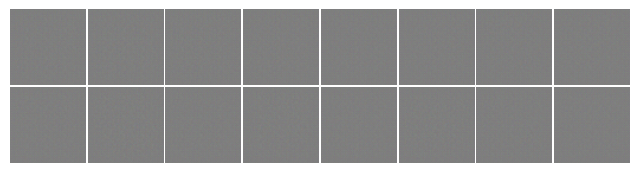

########## EPOCH : 25 : STILL TRAINING ##########


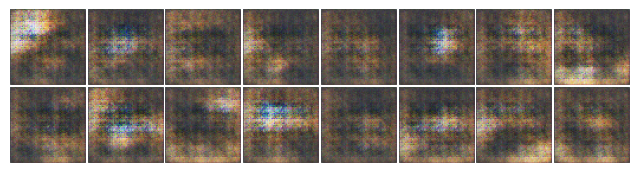

########## EPOCH : 50 : STILL TRAINING ##########


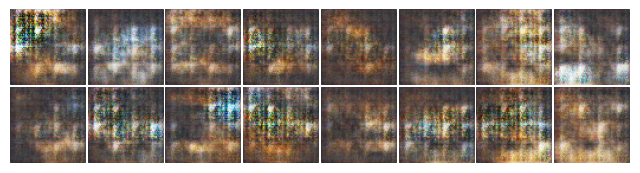

########## EPOCH : 75 : STILL TRAINING ##########


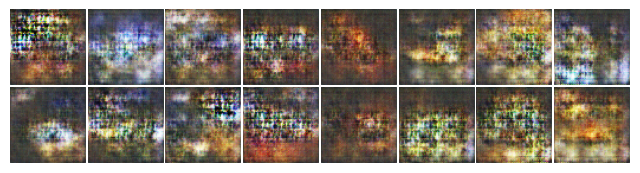

########## EPOCH : 100 : STILL TRAINING ##########


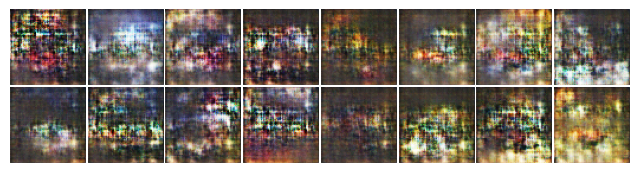

########## EPOCH : 125 : STILL TRAINING ##########


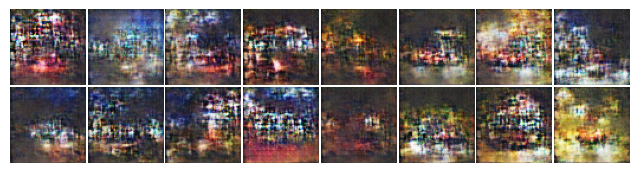

########## EPOCH : 150 : STILL TRAINING ##########


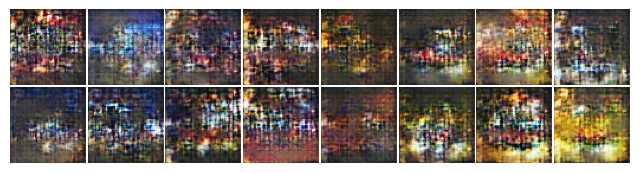

########## EPOCH : 175 : STILL TRAINING ##########


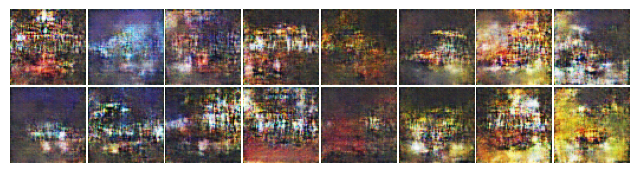

########## EPOCH : 200 : STILL TRAINING ##########


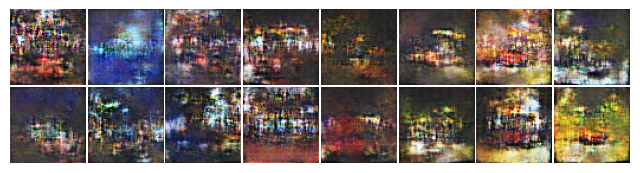

Early stopping after 210 epochs.
########## EPOCH : 209 ##########


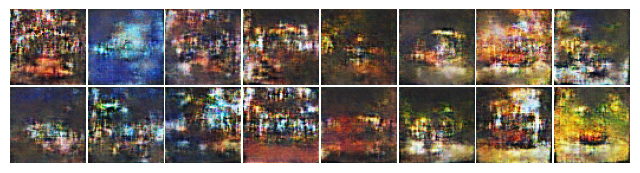

Early stopping after 210 epochs.






In [16]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
Total_losses = []
iters = 0
broken = False
for epoch in range(max_epochs):


    
    netG.train()
    netD.train()
    for batch_idx, X_batch in enumerate(train_loader):
        
        iters+=1
    
        X_norm = 2 * X_batch - 1
        X_norm = X_norm.to(device)
    
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        netD.zero_grad()
        b_size = X_norm.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(X_norm).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, latent_dim, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        
        # Update D
        optimizerD.step()


        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()


        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        Total_losses.append(G_losses[-1]+D_losses[-1])
        

        
    # After Every Epoch
    #schedulerG.step()
    #schedulerD.step()
    
    ##### USING VALIDATION SET FOR EARLY STOPPING #####

    netG.eval()
    netD.eval()
    

    with torch.no_grad():
        
        
        critic_real = netD(X_val_norm)     #.squeeze()
        fixed_test_noise = torch.randn(X_val_norm.shape[0], latent_dim, 1, 1, device=device)
        generated_test_samples = netG(fixed_test_noise)
        critic_fake = netD(generated_test_samples)     #.squeeze()
        current_wasserstein_distance = torch.mean(torch.abs(critic_fake - critic_real)).item()
        w_liss.append(current_wasserstein_distance )
        
        if epoch%25==0:
            with torch.no_grad():
                print(f'########## EPOCH : {epoch} : STILL TRAINING ##########')
                fake = netG(fixed_noise).detach().cpu()
                plot_images(((fake+1.0)/2.0)[:16])
            

        
    if current_wasserstein_distance < previous_wasserstein_distance:
        
        best_Gen_params = netG.state_dict()
        best_Dis_params = netG.state_dict()

        #patience_counter = 0
        

    else:
        patience_counter += 1
    
    previous_wasserstein_distance = current_wasserstein_distance

        
    if patience_counter >= patience:
        
        with torch.no_grad():
            print(f"Early stopping after {epoch+1} epochs.")
            print(f'########## EPOCH : {epoch} ##########')
            fake = netG(fixed_noise).detach().cpu()
            plot_images(((fake+1.0)/2.0)[:16])

        print(f"Early stopping after {epoch+1} epochs.")
        print("\n\n\n")


        break
    
    

___________________________________
# (c)
## Choose the best parameters for DC-GAN (e.g. number of training iterations, learning rate, batch sizes to train the discriminator and generator, etc.) using the validation set V .

_____________________________

## SOL : (c)

A following code of the form below 
```
    for LR in [1e-4, 2e-4, 3e-4, 5e-4, .001, .002, .004, .005,]:
        model.train()

```
was used to search for the best Learning Rate. It is not shown here as the images requires a lot of space. Learning Rate : 0.0002 works best<br><br>

Batch size were also experimented with  <code> batch_size=64</code> was found to be optimal
        

____________________
# (d)
## If needed, use heuristics from the paper 1 to improve training. You can use early stopping criteria and learning rate scheduling based on your choice.

# (e)
## Clearly describe in your python notebook about the training heuristics used in your code and explain why they were useful.
____________________


## SOL : (d) &  SOL : (e)

Below are the use heuristics from the paper :  https://arxiv.org/pdf/1511.06434.pdf <br>
Following is a snipped of the heuristics suggested

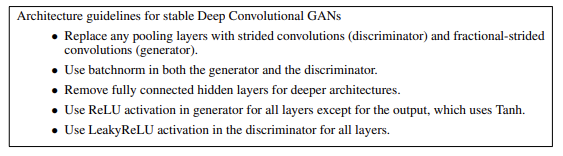

1. BatchNorm was use as suggsted <br><br>
2. ReLU was used in generator as suggested <br><br>
3. LeakyReLU was used in discriminator as suggested <br><br>
4. Strided Convolutions were also used<br><br>
5. Please verify the claims presented here in the code of  <code>class Generator()</code> and <code>class Discriminator()</code> above <br><br>
6. A <code>Tanh()</code> layer was kept at the end of the generator so that images generated in [-1,-1] However to plot them they ere rescaled to [0,1]<br><br>
7. ReLU and LeakyRelu helped in faster Convergence as their gradients did not vanish.<br><br>
8. BatchNorm was useful as before that the images were distorted, It is so because the input is in range [-1,1]. There for at every layer the activations should be normalised<br><br>
9. The paper also suggests "All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02". This was adopted in <code>netD.apply(weights_init)</code>, <code>netG.apply(weights_init)</code> above. This provided better convergence then random initialization<br><br>
10. LR Scheduling was also tried but no significant results were improve for fine tutning. It might need more experimentation. The part of the code is commented out <br><br>
11. The training was done on the augmented dataset that had rotated(+5,-5) and flipped images. This helped increase the dataset size <br><br>


__________________________
# (f) 
## Prepare a plot of the training objective function value against the iterations.
__________________________

## SOL : (f)

Text(0.5, 1.0, 'Total Loss vs Iterations')

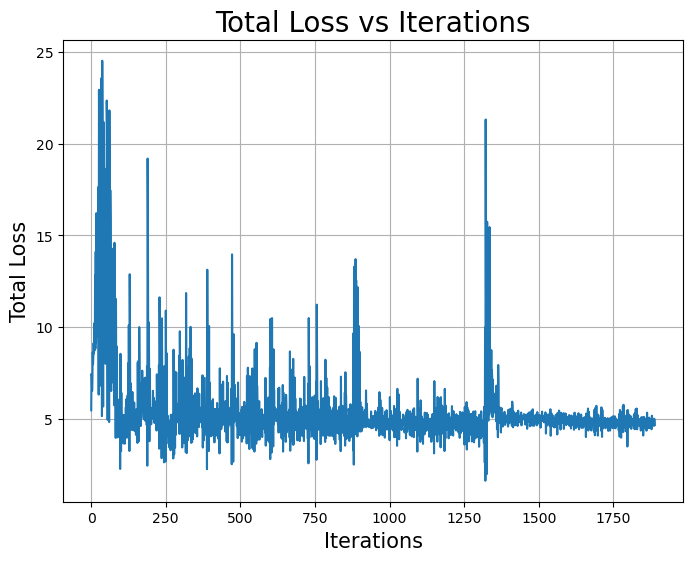

In [17]:
plt.figure(figsize=(8, 6))  # Width=8 inches, Height=6 inches
plt.plot(Total_losses)
plt.grid()
plt.xlabel('Iterations', fontsize=15)
plt.ylabel('Total Loss', fontsize=15)
plt.title('Total Loss vs Iterations', fontsize=20)

__________
# (g) 
## Prepare a plot to depict the discriminator objective function value and the generator objective function value and check if they converge.
_____________

## SOL : (g)

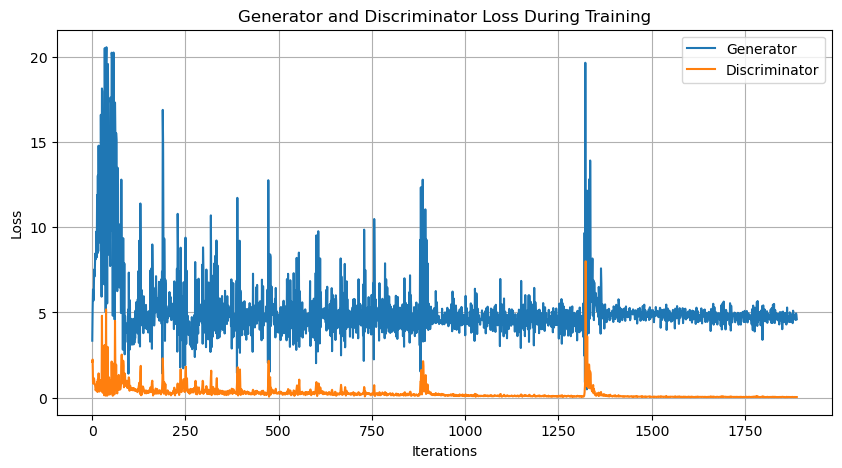

In [18]:
plt.figure(figsize=(10,5))
plt.grid()
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="Generator")
plt.plot(D_losses,label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

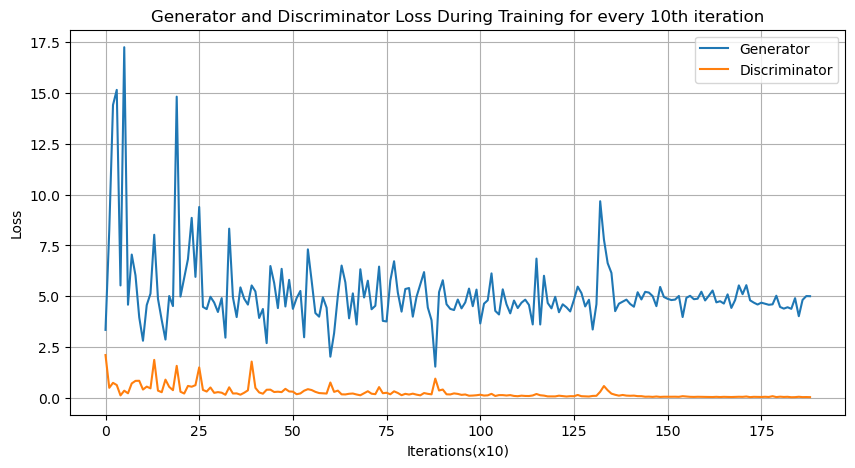

In [19]:
plt.figure(figsize=(10,5))
plt.grid()
plt.title("Generator and Discriminator Loss During Training for every 10th iteration")
plt.plot(G_losses[::10],label="Generator")
plt.plot(D_losses[::10],label="Discriminator")
plt.xlabel("Iterations(x10)")
plt.ylabel("Loss")
plt.legend()
plt.show()

___________________
# (h)
## After training, display 10 images (in a 10 × 1 grid) generated using the generator of your DC-GAN. For each of the 10 images, display 5 original images from the training data D closer to the generated image in a 10 × 5 grid. Comment on the quality of the generated images. Explain the similarity metric you used in the code and justify your choice.
______

In [20]:
fixed_noise = torch.randn(96, latent_dim, 1, 1, device=device)
fake = netG(fixed_noise).detach().cpu()
X_10 = fake[:10]

In [21]:
X_10 = fake[:10]
X_10 = X_10.detach().cpu()

## SOL : (h) : Note the 10x1 grid is drawn along side the closest generated image

Images can be visualised as nothing but vectors in a high dimensional space. Therefore it was mose natural to use the MSE distance of images as a similiarity metric. Two images are compared pixewise by substracting their distance squared and the summation is performed over all the pixels of the image. This is a simple yet effective technique as can be seen in the top5 grid below for each generated image.

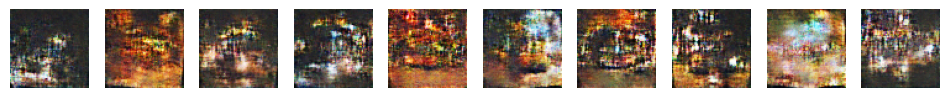

In [22]:
fig, axes = plt.subplots(1, 10, figsize=(12,8))  # Adjust the figsize as needed
for i in range(10):
    image = ((X_10[i]+1.0)/2.0).permute(1, 2, 0).numpy()
    axes[i].imshow(image)
    axes[i].axis('off')

plt.show()

In [23]:
#### FILTER TOP 5 ########
top5 = []
for img in X_10:
    mse_score_liss = []
    for d_img in D:
        mse_score = F.mse_loss(img, d_img)
        mse_score_liss.append(mse_score.item())

    top_5_indices = sorted(range(len(mse_score_liss)), key=lambda i: mse_score_liss[i], reverse=True)[:5]
    top5.append(top_5_indices)

In [24]:
#### GENERATE ALL IMAGES ########
all_images = []
for idx in range(len(X_10)):
    all_images.append(X_10[idx])
    for d_img in D[top5[idx]]:
        all_images.append(d_img)
        
all_images = torch.stack(all_images)

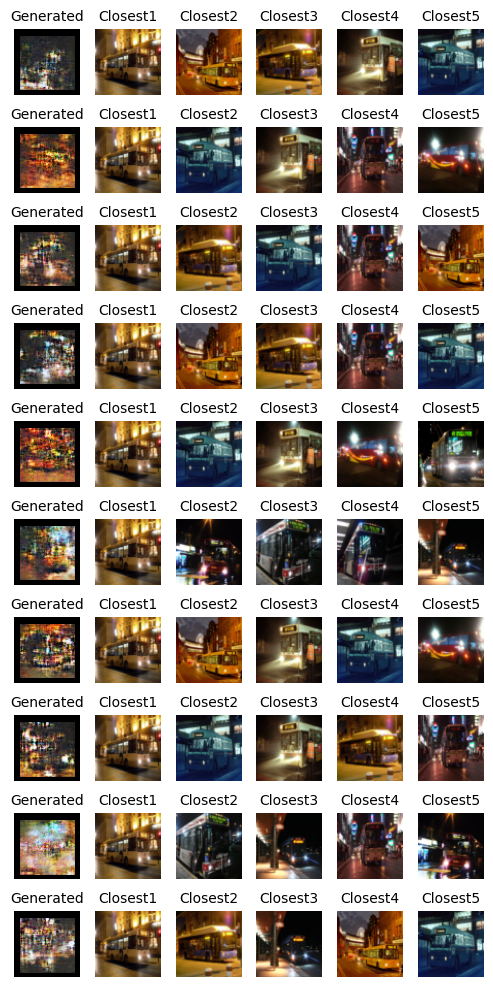

In [25]:
# Sample PyTorch tensor with 60 images shaped 60x3x64x64
images = all_images

# Create a figure and axis for plotting
fig, axes = plt.subplots(nrows=10, ncols=6, figsize=(5, 10))

for i in range(10):
    for j in range(6):
        ax = axes[i, j]
        idx = i * 6 + j
        image = images[idx].permute(1, 2, 0).numpy()

        if j == 0:
            # For the first image in each row, add a thick black outline
            ax.imshow((image+1.0)/2.0)
            rect = plt.Rectangle((0, 0), 64, 64, linewidth=8, edgecolor='black', facecolor='none')
            ax.add_patch(rect)
        else:
            ax.imshow(image)
        if j==0:
            ax.set_title(f'Generated', fontsize=10)
        else:
            
            ax.set_title(f'Closest{j%6}', fontsize=10)
        ax.axis('off')

plt.tight_layout()
plt.show()

_________________________
# (i)
## IMPORTANT: Make sure that the images you have generated using your DC-GAN are meaningful real-looking images. Answers having no meaningful image generation will not be considered for evaluation.
_________________________


## SOL : (i)

Below are the generated images for the trained GAN, please not that these were obtained after a lot of trial and erro. Although not very sharphly but some of them do resemble BUS class

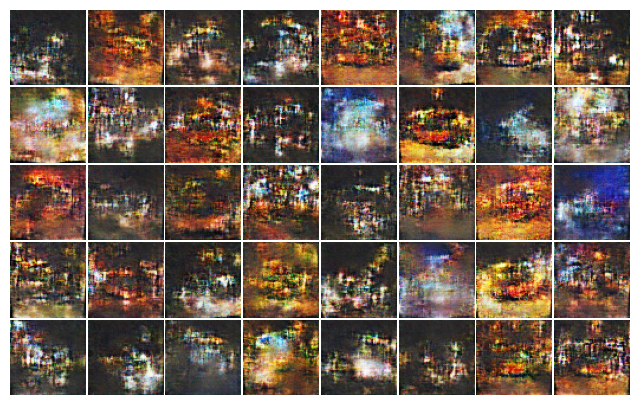

In [26]:
plot_images(((fake+1.0)/2.0)[:40])

_____
# ###############THANK YOU###############
_____